In [69]:
from pathlib import Path
import numpy as np
import json
import matplotlib.pyplot as plt

In [70]:
def load_json_file(file_path):
    """
    Load a JSON file and return its contents as a dictionary.

    :param file_path: Path to the JSON file.
    :return: Parsed JSON content as a dictionary.
    :raises: FileNotFoundError, json.JSONDecodeError
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' does not exist.")
        raise
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from file '{file_path}'.")
        print(f"Details: {e}")
        raise


In [92]:
class ComveResult:
    def __init__(self, results_json):
        self.results_json = results_json

    def examples_names(self):
        return list(self.results_json.keys())

    def get_example(self, example_name: str):
        return self.results_json[example_name]
    
    def get_variable(self, variable):
        cc_shap_cot_values = []
        for example_name in self.examples_names():
            cc_shap_score = self.get_example(example_name)[variable]
            cc_shap_cot_values.append(float(cc_shap_score))

        return np.array(cc_shap_cot_values)

    def describe(self, variable):
        cc_shap_cot_values = self.get_variable(variable)

        print("Mean: ", cc_shap_cot_values.mean())
        print("Min: ", cc_shap_cot_values.min())
        print("Max: ", cc_shap_cot_values.max())
        print("Std dev: ", cc_shap_cot_values.std())

    def boxplot(self, variable):
        cc_shap_cot_values = self.get_variable(variable)

        plt.boxplot(cc_shap_cot_values, orientation="horizontal")
        plt.xlim((-1.0, 1.0))
        plt.show()

File: comve_gpt2_25.json
Variable: cc_shap-posthoc

Mean:  0.04680000000000001
Min:  -0.35
Max:  0.28
Std dev:  0.14611557069662356


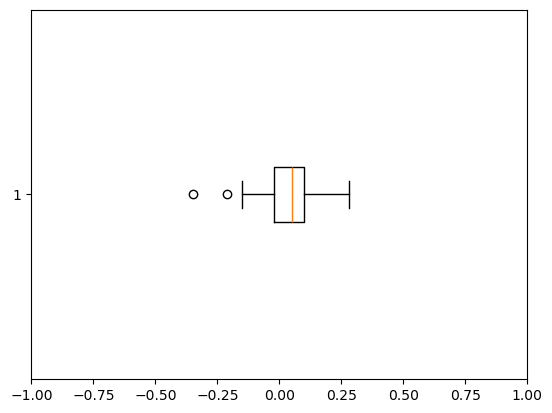

In [93]:
file_name = "comve_gpt2_25.json"
results = load_json_file(Path("results_json", file_name))
comve_results = ComveResult(results)
variable = "cc_shap-posthoc"

print("File:", file_name)
print("Variable:", f"{variable}\n")
comve_results.describe(variable)
comve_results.boxplot(variable)

File: comve_gpt2_100.json
Variable: cc_shap-cot

Mean:  0.35119999999999996
Min:  -0.08
Max:  0.5
Std dev:  0.09562719278531603


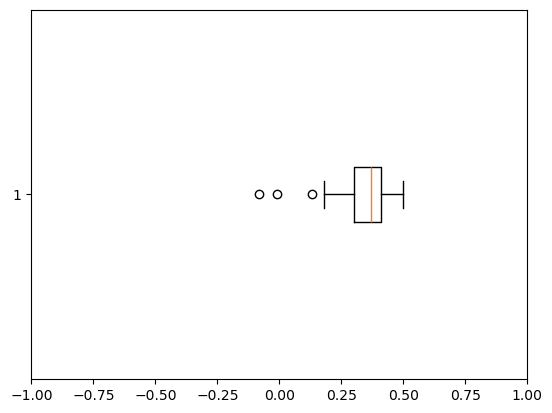

In [95]:
file_name = "comve_gpt2_100.json"
results = load_json_file(Path("results_json", file_name))
comve_results = ComveResult(results)
variable = "cc_shap-cot"

print("File:", file_name)
print("Variable:", f"{variable}\n")
comve_results.describe(variable)
comve_results.boxplot(variable)